# 1B. Data Gridding with MetPy

We are going to grid the data from the previous notebook, and trim down the data in the analysis. This is going to be primarily using MetPy. 

In [1]:
import pandas as pd
import xarray as xr

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy 

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt

import metpy
from metpy.cbook import get_test_data
from metpy.interpolate import (interpolate_to_grid, remove_nan_observations,
                               remove_repeat_coordinates)
from metpy.plots import add_metpy_logo

## Dataset Loading

In [3]:
filename = 'cleaned_geothermal_data.parquet'

df = pd.read_parquet(filename)
print('Dataframe shape', df.shape)
df.head(6)

Dataframe shape (1342867, 22)


,uuid,name,site_name,other_location_name,api,latitude,longitude,state_id,state,state_code,...,bht,max_temperature,depth,shape,datasource,thermal_conductivity,heat_flow,precision_log_source_id,iso_grav,bou_grav
0,525c868b-820a-378a-8202-0bab8ee18479,42135301260000,None,None,42135301260000,31.904,-102.619,15.0,Texas,TX,...,NaN,NaN,1793.75,0101000020E61000000525164298A759C0D28437B57DE7...,MLKay,NaN,NaN,None,NaN,NaN
1,525c9719-b3b8-3a60-9128-55e1fca5092b,42227341000000,None,None,42227341000000,32.115,-101.260,15.0,Texas,TX,...,NaN,NaN,762.00,0101000020E6100000578D6F39A85059C0F5EB9804B90E...,MLKay,NaN,NaN,None,NaN,NaN
2,525c9f62-8700-37a7-bdff-65c314d97bf2,42199322760000,None,None,42199322760000,30.142,-94.432,15.0,Texas,TX,...,NaN,NaN,1232.31,0101000020E61000006A1E7695A49B57C08445459C4E24...,MLKay,NaN,NaN,None,NaN,NaN
3,dcf0c838-7bb5-3453-aace-031d27358123,42199322400000,None,None,42199322400000,30.142,-94.432,15.0,Texas,TX,...,NaN,NaN,1225.91,0101000020E61000005FBEABD4A29B57C0BF0F07095124...,MLKay,NaN,NaN,None,NaN,NaN
4,e93d2d24-4a4d-3e87-a207-3f1f1a9451b8,42199322810000,None,None,42199322810000,30.142,-94.432,15.0,Texas,TX,...,NaN,NaN,1240.23,0101000020E610000069B97DA0A69B57C02ED3E5835424...,MLKay,NaN,NaN,None,NaN,NaN
5,525cae4a-52ed-370d-854c-c2bbfef4057b,42047000500000,None,None,42047000500000,27.253,-98.166,15.0,Texas,TX,...,NaN,NaN,2926.08,0101000020E61000000475CAA39B8A58C09EBBB8E8BF40...,MLKay,NaN,NaN,None,NaN,NaN


## Quick Data Viz

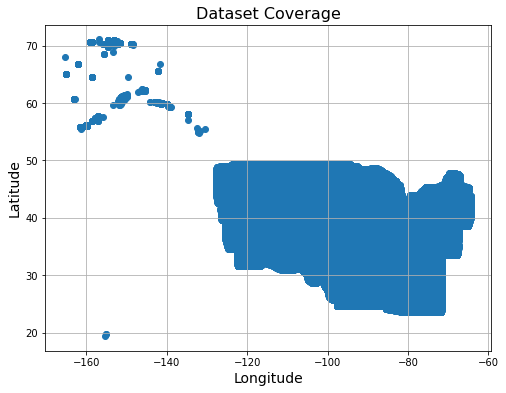

In [4]:
plt.figure(figsize=(8,6))

plt.scatter(df.longitude.values,
            df.latitude.values)

plt.title('Dataset Coverage', size=16)
plt.xlabel('Longitude', size=14)
plt.ylabel('Latitude', size=14)

plt.grid()

Looks like we have some data in Alaska and Hawai'i, while cool states, the economics are a lot different than the western US. Let's remove these states from the analysis.

Let's drop AK and HI, and only look at western states (-95 and west Longitude)

In [5]:
lat_cutoff = 50
long_cutoff_east = -103
long_cutoff_west = -125

df = df[df.latitude <= lat_cutoff]
df = df[(df.longitude <= long_cutoff_east) & (df.longitude >= long_cutoff_west)]

print('Dataframe shape', df.shape)

Dataframe shape (262750, 22)


Let's make a new plot, and color-code the dot by depth

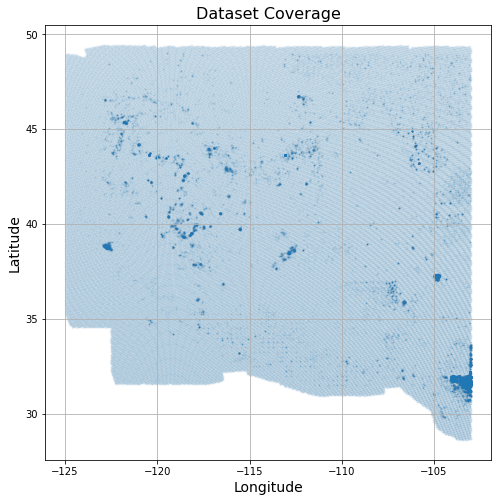

In [6]:
plt.figure(figsize=(8,8))

plt.scatter(df.longitude.values,
            df.latitude.values,
            s=0.9, #size
            alpha=0.05,
            label='Datapoint')

plt.title('Dataset Coverage', size=16)
plt.xlabel('Longitude', size=14)
plt.ylabel('Latitude', size=14)
plt.grid()

Let's look at the range of depths in more detail:

Median Depth 950.98


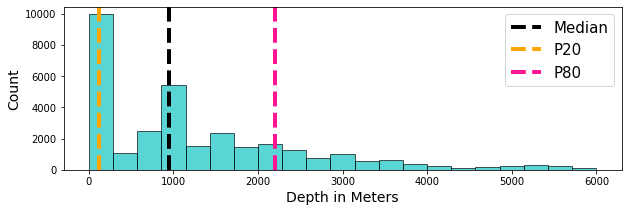

In [7]:
df_depths = df.dropna(subset=['depth'])

plt.figure(figsize=(10,3))

plt.hist(df_depths.depth.values, color='c', edgecolor='k', alpha=0.65, bins=21);
plt.ylabel('Count', size=14)

# add a Median line to the histogram
plt.axvline(np.nanmedian(df_depths.depth.values), color='k', linestyle='dashed', linewidth=4, label='Median')
plt.axvline(np.nanpercentile(df_depths.depth.values, 20, axis=0), color='orange', linestyle='dashed', linewidth=4, label='P20')
plt.axvline(np.nanpercentile(df_depths.depth.values, 80, axis=0), color='deeppink', linestyle='dashed', linewidth=4, label='P80')

plt.xlabel('Depth in Meters', size=14)
plt.legend(prop={'size': 15})

print('Median Depth', np.median(df_depths.depth.values))

## Split into dataframes based on depth

In [8]:
shallow, deep = 200, 2000

In [9]:
df_shallow = df[df.depth < shallow]
df_medium = df[(df.depth >= shallow) & (df.depth <= deep)]
df_deep = df[df.depth > deep]

In [10]:
print('Sanity check:')
print('Shallow, min, max:', df_shallow.depth.min(), df_shallow.depth.max())
print('Medium, min, max:', df_medium.depth.min(), df_medium.depth.max())
print('Deep, min, max:', df_deep.depth.min(), df_deep.depth.max())

Sanity check:
Shallow, min, max: 3.1 199.9
Medium, min, max: 200.0 2000.0
Deep, min, max: 2000.1 5997.55


# MetPy Gridding

[MetPy](https://github.com/Unidata/MetPy) supported by [Unidata](https://www.unidata.ucar.edu/) has a nice interface for gridding comapred to scipy. The tutorial is [here](https://unidata.github.io/MetPy/latest/examples/gridding/Point_Interpolation.html#sphx-glr-examples-gridding-point-interpolation-py).

In [11]:
df_ = []
# The dataframe, and column needs to be changed below
df_ = df_medium.dropna(subset=['bht'])

x = df_.longitude
y = df_.latitude
z = df_.bht

In [12]:
img = [] # used for debugging

gx, gy, img = interpolate_to_grid(x, y, z, interp_type='cressman', 
                                  minimum_neighbors=2, hres=0.15, search_radius=.95);

Lets plot it up!

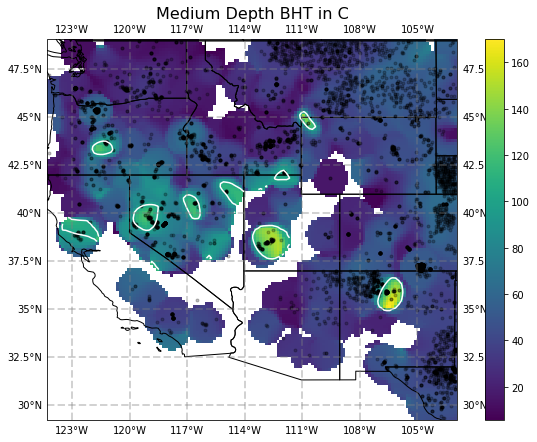

In [13]:
# colormap
cmap = 'viridis'

# maksing
img = np.ma.masked_where(np.isnan(img), img)

plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES)

#pcolormesh uses the output of the previous cell
plt.pcolormesh(gx, gy, img, cmap=cmap)
plt.colorbar()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.35, linestyle='--')

# Adding a quick contour
plt.contour(gx, gy, img, [100], colors='white')

# Adding the initial dataset points
plt.scatter(x,y, marker = '.', color='black', alpha=0.25)
plt.title('Medium Depth BHT in C', size=16)

plt.savefig('Medium_depthBHT.png', transparent=True, dpi=400)

## Gravity next:

Note, could not get this to run on a large machine. This dataset does work with verde block reduce. 

In [14]:
df_ = []
# The dataframe, and column needs to be changed below
df_ = df.dropna(subset=['iso_grav'])

x = df_.longitude
y = df_.latitude
z = df_.iso_grav

In [15]:
np.shape(x)

(230825,)

In [16]:
np.shape(z)

(230825,)

In [ ]:
img = [] # used for debugging

gx, gy, img = interpolate_to_grid(x, y, z, interp_type='cressman', 
                                  minimum_neighbors=5, hres=5, search_radius=5);

In [ ]:
# colormap
cmap = 'viridis'

# maksing
img = np.ma.masked_where(np.isnan(img), img)

plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES)

#pcolormesh uses the output of the previous cell
plt.pcolormesh(gx, gy, img, cmap=cmap)
plt.colorbar()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.35, linestyle='--')

# Adding a quick contour
plt.contour(gx, gy, img, [0], colors='white')

# Adding the initial dataset points
plt.scatter(x,y, marker = '.', color='black', alpha=0.25)
plt.title('gravity', size=16)